In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7fe08839d0f0>


In [2]:
base_input = '../../input_files/ap2_repeat.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['default_assoc', 1.0]
['A']
['B']
['S']
Parsing rule...
['A(a)+A(b)<->A(a!1).A(a!1)', '', 'G=-20']
['A', 'A', '']
['A(a)+A(b)', 'A(a!1).A(a!1)']
GGGGGGGGGgg
Parsing rule...
['A(c)+S(a)<->A(c!1).S(a!1)', '', 'G=-20']
['A', 'S', '']
['A(c)+S(a)', 'A(c!1).S(a!1)']
GGGGGGGGGgg
Parsing rule...
['B(b)+A(b)<->B(b!1).A(b!1)', '', 'G=-20']
['B', 'A', '']
['B(b)+A(b)', 'B(b!1).A(b!1)']
GGGGGGGGGgg
Parsing rule...
['B(c)+S(b)<->B(c!1).S(b!1)', '', 'G=-20']
['B', 'S', '']
['B(c)+S(b)', 'B(c!1).S(b!1)']
GGGGGGGGGgg
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20e0c18>, 'copies': tensor([300.], dtype=torch.float64)})
Node-2 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20e0c18>, 'copies': tensor([300.], dtype=torch.float64)})
-----
{'A'}
{'A'}
set()
Steric hindrance detected
Node-1 :  (0, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20e0c18>, 'copies': tensor([300.], dtype=torch.float64)})
Node-2 :  (1, {'struct': <networkx.classes.graph.Gr

Node-1 :  (9, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20cab00>, 'copies': tensor([0.], dtype=torch.float64)})
Node-2 :  (7, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20720b8>, 'copies': tensor([0.], dtype=torch.float64)})
-----
{'S', 'A'}
{'S', 'B', 'A'}
set()
Steric hindrance detected
Node-1 :  (9, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20cab00>, 'copies': tensor([0.], dtype=torch.float64)})
Node-2 :  (8, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20ca940>, 'copies': tensor([0.], dtype=torch.float64)})
-----
{'S', 'A'}
{'B', 'A'}
{'S'}
Steric hindrance detected
Node-1 :  (9, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20cab00>, 'copies': tensor([0.], dtype=torch.float64)})
Node-2 :  (9, {'struct': <networkx.classes.graph.Graph object at 0x7fdff20cab00>, 'copies': tensor([0.], dtype=torch.float64)})
-----
{'S', 'A'}
{'S', 'A'}
set()
Steric hindrance detected
Node-1 :  (9, {'struct': <networkx.classes.grap

In [3]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    print(rn.network.nodes[n]['struct'].edges())
    for k,v in rn.network[n].items():
        print(v)
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0 -- A
[]
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 9}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 10}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-80.], dtype=torch.float64), 'uid': 11}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 12}
1 -- B
[]
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64

In [4]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
#new_kon = [0.2244, 0.2244, 0.2255, 1.6039, 1.6039, 1.6040] # M-1 s-1   
#new_kon = [0.0125, 0.1947, 0.0125, 3.6241, 3.4263, 3.4258] #Max yield Simruntime = 10sec
# new_kon = new_kon + Tensor([1.]*np.array(1e0))
# new_kon = new_kon + Tensor([14.6166, 10.6142, 10.6000, 10.5714, 10.6195, 21.7997, 21.7183, 35.2243, 0.8175,  0.8174, 29.6708, 35.8126,  
#                             0.8172,  0.8173, 30.6776,  4.2609, 
#                             4.2914, 21.8148, 21.6135, 20.7146, 20.0116])
new_kon = new_kon + Tensor([ 1.7714,  1.6740, 46.5603, 48.6187,  0.2016,  0.1839,  0.1081,  0.2268,
        12.5121,  8.9197,  9.1507, 10.5266,  0.3288, 13.1061, 12.3890])
update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 9}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 10}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-80.], dtype=torch.float64), 'uid': 11}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 12}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 4}
{'k_on'

In [5]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
vec_rn.reset()
# print(vec_rn.kon)
runtime =10000
sim = VecSim(vec_rn, runtime, device='cpu')
y = sim.simulate()

A
Reactant Sets:
B
Reactant Sets:
S
Reactant Sets:
AB
Reactant Sets:
(0, 1)
AS
Reactant Sets:
(0, 2)
A
Reactant Sets:
(0,)
BS
Reactant Sets:
(1, 2)
ABS
Reactant Sets:
(2, 3)
(1, 4)
(0, 6)
AB
Reactant Sets:
(0, 3)
(1, 5)
AS
Reactant Sets:
(0, 4)
(2, 5)
ABS
Reactant Sets:
(5, 6)
(8, 2)
(9, 1)
(0,)
(7,)
tensor([[-1., -1., -2.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,
          0.,  1.,  1.,  2., -0., -0., -0., -0., -0., -0.,  1.,  1., -0.,  1.,
         -0., -0.],
        [-1.,  0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         -1.,  1., -0., -0.,  1.,  1.,  1., -0., -0., -0., -0., -0., -0., -0.,
         -0.,  1.],
        [ 0., -1.,  0., -1.,  0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
          0., -0.,  1., -0.,  1., -0., -0.,  1.,  1.,  1., -0., -0., -0., -0.,
         -0., -0.],
        [ 1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
          0., -1., -0., -0., -0., -0., -0.,  1., -0., -0.,  1., -0., -0., -0.,
      

<IPython.core.display.Javascript object>


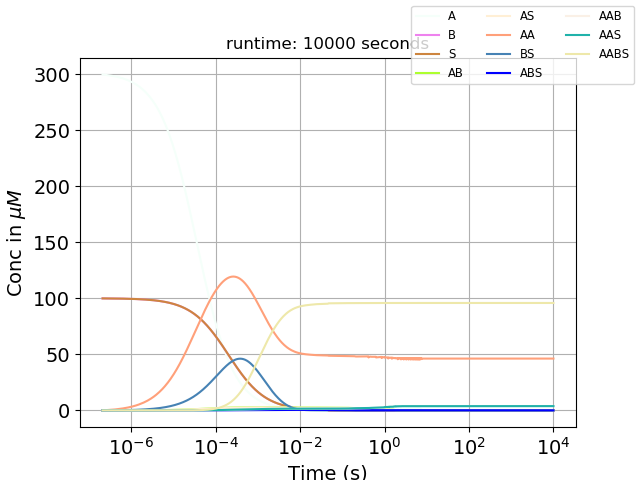

/media/Data1/adip/software/anaconda3/envs/steric_free_sim/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


In [17]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig, ax = plt.subplots()
# nodes_list = ['A','B','M','S','AB','AM','AS','MS','BM','ABM','AMS','ABS','BMS','ABMS']
nodes_list_repeat = ['A','B','S','AB','AS','AA','BS','ABS','AAB','AAS','AABS']
sim.plot_observable(nodes_list_repeat, ax=ax,legend=False,seed=710)
ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
ax.set_xscale("log")
fig.legend(handles,nodes_list_repeat,loc='best',fancybox=True,ncol=3,fontsize='small',markerscale=1.0)
ax.grid(which="major",axis="both")

In [7]:
# node_map = {}
# for node in rn.network.nodes():
#     node_map[gtostr(rn.network.nodes[node]['struct'])] = node

# print(node_map)
# def get_max_edge(n):
#     """
#     Calculates the max rate (k_on) for a given node
#     To find out the maximum flow path to the final complex starting from the current node.
    
#     Can also calculate the total rate of consumption of a node by summing up all rates. 
#     Can tell which component is used quickly.
#     """
#     try:
#         edges = rn.network.out_edges(n)
#         #Loop over all edges
#         #Get attributes
#         kon_max = -1
#         next_node = -1

#         kon_sum = 0
#         total_flux_outedges = 0
#         total_flux_inedges = 0
#         if len(edges)==0:
#             return(False)
            
#         for edge in edges:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]
#             kon_sum+=temp_kon
            
#             if temp_kon > kon_max:
#                 kon_max = temp_kon
#                 next_node=edge[1]
             
#         return(kon_max,next_node,kon_sum)
#     except Exception as err:
#         raise(err)

        
# def get_node_flux(n):
#     total_flux_outedges = 0
#     total_flux_inedges = 0
#     #Go over all the out edges
#     edges_out = rn.network.out_edges(n)
#     if len(edges_out)>0:

#         for edge in edges_out:
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             #print(data)
#             #Get uid
#             uid = data['uid']

#             #Get updated kon
#             temp_kon = vec_rn.kon[uid]

#             #Calculate k_off also
#             std_c = Tensor([1e6])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Getting conc. of reactants and products
#             #Get product
#             prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

#             #Net flux from this edge = Generation - consumption
#             edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
#             #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

#             total_flux_outedges+=edge_flux
    
#     #Now go over all the in edges
#     edges_in = rn.network.in_edges(n)
#     react_list = []
#     if len(edges_in) > 0:
#         for edge in edges_in:
#             if edge[0] in react_list:
#                 continue
#             data = rn.network.get_edge_data(edge[0],edge[1])
#             uid = data['uid']


#             #Get generation rates; which would be kon
#             temp_kon = vec_rn.kon[uid]

#             #Get consumption rates; which is k_off
#             std_c = Tensor([1e6])
#             l_kon = torch.log(temp_kon)
#             l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
#             koff = torch.exp(l_koff)

#             #Get conc. of reactants and products
#             prod = gtostr(rn.network.nodes[edge[1]]['struct'])
#             #Get other reactant
#             react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
#             react_list.append(node_map[react])
#             #Net flux from this edge = Generation - consumption
#             edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
#             #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

#             total_flux_inedges+=edge_flux_in
#     net_node_flux = total_flux_outedges + total_flux_inedges
    
#     return(net_node_flux)
    
# pathway = []
# kon_sumarray = []
# total_con_rate = {}
# net_flux = {}
# for n in rn.network.nodes():
    
#     n_str = gtostr(rn.network.nodes[n]['struct']) 
    
#     paths = [n_str]
#     kon_sum = 0
#     temp_node = n
#     max_edge = True
#     consumption_rate = 0
#     if n < len(rn.network.nodes()):#num_monomers:
# #         print("Current node: ")
# #         print(n_str)
#         while max_edge:
#             max_edge = get_max_edge(temp_node)
#             if max_edge:
#                 total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
#                 temp_node = max_edge[1]
#                 kon_sum += max_edge[0].item()
                
                
# #                 print("Next node: ")
# #                 print(temp_node)

#                 paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
#             else:
#                 break
#         pathway.append(paths)
#         kon_sumarray.append(kon_sum)
#         paths=[]
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")
#     print("|                                                                             |")
#     node_flux = get_node_flux(n)
#     net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
#     print("|                                                                             |")
#     print("-------------------------------------------------------------------------------")
#     print("-------------------------------------------------------------------------------")

# print(pathway)
# print(kon_sumarray)

# #print(total_con_rate)

In [8]:
# for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
#     print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)
print("Total COpies of A: ", vec_rn.copies_vec[0]+vec_rn.copies_vec[3]+vec_rn.copies_vec[4]+vec_rn.copies_vec[7]+2*(vec_rn.copies_vec[5]+vec_rn.copies_vec[8]+vec_rn.copies_vec[9]+vec_rn.copies_vec[10]))

tensor([3.0882e-01, 5.6350e-14, 2.5244e-28, 5.2625e-11, 5.2637e-11, 4.6271e+01,
        0.0000e+00, 3.8144e-06, 3.8297e+00, 3.8301e+00, 9.5915e+01],
       dtype=torch.float64, grad_fn=<MaxBackward2>)
Parameter containing:
tensor([ 1.7714,  1.6740, 46.5603, 48.6187,  0.2016,  0.1839,  0.1081,  0.2268,
        12.5121,  8.9197,  9.1507, 10.5266,  0.3288, 13.1061, 12.3890],
       dtype=torch.float64, requires_grad=True)
Total COpies of A:  tensor(300.0000, dtype=torch.float64, grad_fn=<AddBackward0>)


In [9]:
# for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
#     print(k," : ", v.item())

In [10]:
import networkx as nx
labels = nx.get_node_attributes(rn.network, 'struct')
labels = {key:gtostr(labels[key]) for key in labels.keys()}
# nx.draw_networkx(rn.network,labels=labels,node_size=1000)

<IPython.core.display.Javascript object>


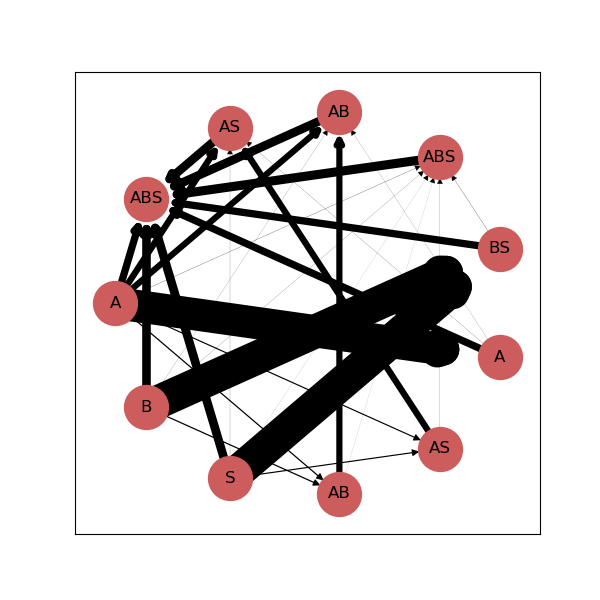

In [11]:
fig,ax = plt.subplots(figsize=(6,6))
sl_pos = nx.shell_layout(rn.network)
nx.draw_networkx(rn.network,pos=sl_pos,labels=labels,node_size=1000,node_color='indianred',ax=ax,edgelist=[])
# new_kon = 0.5*np.array([0.8179, 0.8172, 0.8174, 0.8174, 0.8218, 0.0296, 0.0295, 4.6052, 0.8188,
#         0.8188, 7.7299, 5.4280, 0.8199, 0.8183, 7.1332, 4.9835, 4.9838, 0.0307,
#         0.0315, 5.2260, 5.2278])

if vec_rn.rxn_coupling:
    label_kon = 0.5*sim.coupled_kon.detach().numpy()
else:
    label_kon = 0.5*vec_rn.kon.detach().numpy()
    
sample_colors = ['black','black','black','black','olivedrab','orchid','darkorange','teal','']
edge_widths = []
edge_colors= []
for edge,uid in uid_dict.items():
    edge_widths.append(label_kon[uid])
    #edge_colors.append(sample_colors[uid])
nx.draw_networkx_edges(rn.network,pos=sl_pos,width=edge_widths,label=edge_widths,arrowsize=10,min_target_margin=15.0)


In [12]:
# fig,ax = plt.subplots(figsize=(6,6))
# nx.draw_networkx(rn.network,pos=sl_pos,labels=labels,node_size=1000,node_color='indianred',ax=ax)

In [13]:

poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

TypeError: unsupported operand type(s) for *: 'Symbol' and 'NoneType'